# Intent List
#### 0 Show Dataset
#### 1  Plot histogram of a column
#### 2 Correlation matrix
#### 3 Print shape of df
#### 4 Bar plot
#### 5 Pie plot
#### 6 Install a package
#### 7 List all columns of a df
#### 8 Describe df
#### 9 Aggregation
#### 10 Line plot
#### 11 Scatter plot
#### 12 Heatmap


In [51]:
import pandas as pd
import torch
import numpy as np

In [52]:
datapath = 'extra.csv'
df = pd.read_csv(datapath)
df.head()

,intent_id,intent
0,8,pie chart of ornkvapan column of mydf grouped ...
1,15,show a heatmap with egooxbsihbeahmqq on x axis...
2,0,import pandas
3,10,list all columns of tempdf
4,4,get histogram of fur_m in tempdf


In [53]:
df=df[~df['intent_id'].isin([0,1,2])]
df['intent_id']=df['intent_id']-3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
df.head()

,intent_id,intent
0,5,pie chart of ornkvapan column of mydf grouped ...
1,12,show a heatmap with egooxbsihbeahmqq on x axis...
3,7,list all columns of tempdf
4,1,get histogram of fur_m in tempdf
5,5,pie chart of hacrk of mydf coloured by gnkxru_...


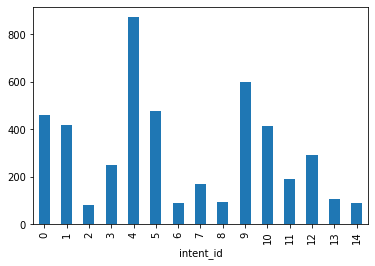

In [55]:
df.groupby(['intent_id']).size().plot.bar()

In [56]:
df['intent_id'].unique()

array([ 5, 12,  7,  1,  4,  0, 10,  9, 11,  3,  2, 13,  8, 14,  6])

In [14]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 3.3 MB 38.1 MB/s 
     |████████████████████████████████| 61 kB 508 kB/s 
     |████████████████████████████████| 895 kB 49.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [15]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
example_text = 'show me top 50 records'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

bert_input

{'input_ids': tensor([[ 101, 1437, 1143, 1499, 1851, 3002,  102,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}

In [17]:
example_text = tokenizer.decode(bert_input.input_ids[0])
example_text

'[CLS] show me top 50 records [SEP] [PAD] [PAD] [PAD]'

In [57]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label for label in df['intent_id']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['intent']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [58]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

3670 459 459


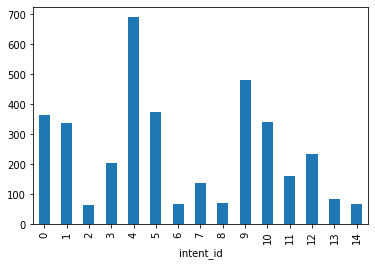

In [59]:
df_train.groupby(['intent_id']).size().plot.bar()

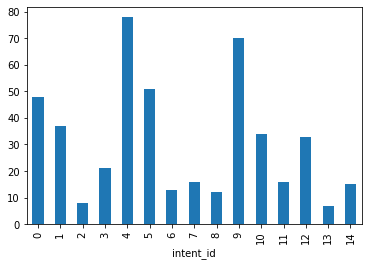

In [60]:
df_val.groupby(['intent_id']).size().plot.bar()

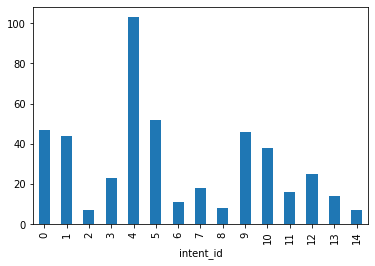

In [61]:
df_test.groupby(['intent_id']).size().plot.bar()

In [62]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 18)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [63]:
# model = BertClassifier()
# model.save()

In [16]:
torch.save(model.state_dict(), 'checkpoint.pth')
state_dict = torch.load('checkpoint.pth')
model.load_state_dict(state_dict)

In [64]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 3
model = BertClassifier()
LR = 1e-6
              
train(model, df, df_val, LR, EPOCHS)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2294/2294 [15:45<00:00,  2.43it/s]


Epochs: 1 | Train Loss:  0.798                 | Train Accuracy:  0.671                 | Val Loss:  0.322                 | Val Accuracy:  0.965


100%|██████████| 2294/2294 [15:45<00:00,  2.43it/s]


Epochs: 2 | Train Loss:  0.183                 | Train Accuracy:  0.995                 | Val Loss:  0.113                 | Val Accuracy:  1.000


100%|██████████| 2294/2294 [15:43<00:00,  2.43it/s]


Epochs: 3 | Train Loss:  0.071                 | Train Accuracy:  1.000                 | Val Loss:  0.048                 | Val Accuracy:  1.000


In [56]:
torch.save(model.state_dict(), 'bert_2_large_intent.pth')
# state_dict = torch.load('bert_large_intent.pth')
# model.load_state_dict(state_dict)

In [20]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)


Test Accuracy:  0.978


In [73]:
input=["show shape of data"]

output=tokenizer(input, padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
  model = model.cuda()

with torch.no_grad():
  result=model(output['input_ids'].to(device),output['attention_mask'].to(device))
  print(np.argmax(result.cpu().numpy()))

3


6
